<center><h1>Transfer Learning for Video Classification</h1></center>
<center><h3>Maharajwala_Raj_Final_Project</h1></center>

<br>
<br>

Name: Raj Vijay Maharajwala
<br>
Github Username: RajMaharajwala
<br>
USC ID: 4863-3649-66

**Video Classification**:
```
Videos can be viewed as a sequences of individual images; therefore, one can dealwith video classification as performing image classificationLtimes,  whereListhe number of frames in a video.  However,  this setting has a problem:  it doesnot capture the temporal nature of the video.  That is why we use RNN-CNN forvideo classification.  Training RNN-CNN’s needs a lot of computational resources,and  it  might  sometimes  be  excessive,  so  in  this  project  we  will  take  a  simplerapproach
```

**Moving Averages over Predictions for Video ClassificationIn** 
```
This approach, we train a CNN for image classification, and turn it into a videoclassifier  using  moving  averages. If  we  rely  on  only  one  or  a  few  frames  of  a video for classifying it, we will observe a phenomenon called flickering, which is assigning different labels to different frames of a video in the same class. 

However,if we use an average of predictions of probabilities for multiple frames, we will get a more reliable prediction for a video.
```

In [4]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import random
import shutil
import math
import logging
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

## 1. Data Exploration and Pre-processing

```
i. Images in each class are given in separate folders in the folder "Sport Images". We have several hundreds of images for five classes of sport activities, namely baseball, basketball, fencing, tennis, and volleyball.

ii. Randomly select ⌈0.7 ni⌉ images from each folder as your training set, ⌈0.15 ni⌉ as  validation  set,  and  the  rest  as  your  test  set,  where ni is  the  number  of images in folder i and ⌈x⌉ the ceiling of x.
```

In [ ]:
# Set up logging
logging.basicConfig(filename='../logs/image_split.log', filemode='w', format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

# Set the path to the directory containing the sport images
images_dir = "../Data/Sport Images/"

# Set the fractions for the split
train_fraction = 0.7
val_fraction = 0.15

# Loop through each sport category folder
for sport_folder in glob.glob(images_dir + "*"):
    sport_folder = sport_folder.replace("\\", "/")
    if sport_folder == "../Data/Sport Images/Image URLs":
        continue
    if not os.path.isdir(sport_folder):
        continue

    logging.info(f'Splitting images in {sport_folder}')
    
    try:
        # Count the number of images in the current sport category folder
        sport_images = glob.glob(sport_folder + "/*")
        sport_images = [x.replace('\\', '/') for x in sport_images]
        num_images = len(sport_images)
        logging.info(f'Number of images: {num_images}')

        # Calculate the number of images for each split
        num_train_images = math.ceil(train_fraction * num_images)
        num_val_images = math.ceil(val_fraction * num_images)
        num_test_images = num_images - num_train_images - num_val_images

        # Shuffle the list of images
        random.shuffle(sport_images)

        # Split the images into the three sets
        train_images = sport_images[:num_train_images]
        val_images = sport_images[num_train_images:num_train_images+num_val_images]
        test_images = sport_images[num_train_images+num_val_images:]

        # Create the training, validation, and test directories for the current sport category
        for split_name in ["training", "validation", "test"]:
            split_dir = sport_folder + "/" + split_name
            if not os.path.exists(split_dir):
                os.makedirs(split_dir)

        # Copy the images to the corresponding split directories
        for images, folder in ((train_images, "training"), (val_images, "validation"), (test_images, "test")):
            for image in images:
                dst = os.path.join(os.path.dirname(image), folder, os.path.basename(image))
                logging.info(f'Copying {os.path.basename(image)} to {folder} folder')
                shutil.copyfile(image, dst)
    except Exception as e:
        logging.error(f'Error splitting images in {sport_folder}: {str(e)}')


```
iii. In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.
```

In [ ]:
link_non_resized = []
def resize_image(img_path, size=(224, 224)):
    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, size)
        return img
    except: 
        link_non_resized.append(img_path)
        return link_non_resized

def Testing_on_oneimage(img_path, size=(224, 224)):
    shutil.copyfile(img_path, '../Testing_Script/original_image.jpg')
    img = resize_image(img_path, size)
    cv2.imwrite("../Testing_Script/resized_image.jpg", img)

Testing_on_oneimage('../Data/Sport Images/baseball/00000001.jpg')

In [ ]:
for type in ["training","validation","test"]:
    sport_images = glob.glob(f"../Data/Sport Images/*/{type}/*")
    sport_images = [x.replace('\\', '/') for x in sport_images]        
    for path in sport_images:
        try:
            img = resize_image(path, size=(224, 224))
            cv2.imwrite(path, img)
        except:
            #All Gif files are causing Error so removed it
            os.remove(path)

## 2. Transfer Learning for Image Classification

i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. 

The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. 

The dataset in this task has only several hundred images per class. Given that we have 5 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will use pre-trained models ResNet50, EfficientNetBO, and VGG16. For both pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

https://builtin.com/data-science/transfer-learning

ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV

In [ ]:
training_sport_images = glob.glob("../Data/Sport Images/*/training/*")
training_sport_images = [x.replace('\\', '/') for x in training_sport_images]
Sample_train_img = training_sport_images[:5] # Sample 
Sample_Output_img_base = '../Testing_Script/img'
print(Sample_train_img)

['../Data/Sport Images/baseball/training/00000001.jpg', '../Data/Sport Images/baseball/training/00000002.jpeg', '../Data/Sport Images/baseball/training/00000003.png', '../Data/Sport Images/baseball/training/00000007.jpg', '../Data/Sport Images/baseball/training/00000009.jpg']


In [ ]:
# Define a list of image augmentation functions
augmentations = [
    lambda img: cv2.flip(img, 0),  # flip vertically
    lambda img: cv2.flip(img, 1),  # flip horizontally
    lambda img: cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE), # rotate 90 degrees clockwise
    lambda img: cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE), # rotate 90 degrees counterclockwise
    lambda img: cv2.rotate(img, cv2.ROTATE_180),  # rotate 180 degrees
    lambda img: cv2.GaussianBlur(img, (5, 5), 0),  # apply Gaussian blur
    lambda img: cv2.resize(img, (int(1.2 * img.shape[1]), int(1.2 * img.shape[0])), interpolation=cv2.INTER_CUBIC),  # zoom in
    lambda img: cv2.resize(img, (int(0.8 * img.shape[1]), int(0.8 * img.shape[0])), interpolation=cv2.INTER_CUBIC),  # zoom out
    lambda img: cv2.warpAffine(img, np.float32([[1, 0, 50], [0, 1, 50]]), (img.shape[1], img.shape[0])),  # translate
    lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),  # convert to grayscale
    lambda img: cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)),  # apply histogram equalization to grayscale image
]

def test_data_augment(Sample_Output_img_base):
    for filename in Sample_Output_img_base:
        image = cv2.imread(filename)
        element = filename.split("/")[-1].split(".")[0]
        # Apply each augmentation function to the image and save the augmented image to the output folder
        for i, augmentation in enumerate(augmentations):
            image_aug = augmentation(image)
            output_filename_path= f'../Testing_Script/augment/augment_{element}_{i}.jpg'
            cv2.imwrite(output_filename_path, image_aug)
            
test_data_augment(Sample_train_img)

In [ ]:
%%time
errors_imgs = []
# Iterate over each image file in the input folder
for filename in training_sport_images:
    image = cv2.imread(filename)
    element = filename[:filename.rfind('.')] # without extention
    for i, augmentation in enumerate(augmentations):
        try:
            image_aug = augmentation(image)
            output_filename = f'{element}_{i}.jpg'
            #print(output_filename)
            cv2.imwrite(output_filename, image_aug)
        except:
            errors_imgs.append(filename)

CPU times: total: 1min 34s
Wall time: 1min 12s


In [ ]:
errors_imgs

[]

To prevent from overfitting I am randomly reducing number of images

In [ ]:
# To prevent overfitting to model I am randomly dropping augmented images
images_to_remove = random.sample(augmented_train, 14444)
# print(images_to_remove)
num_to_drop = len(augmented_train) - 10713
to_drop = random.sample(augmented_train, num_to_drop)
for file_path in to_drop:
    os.remove(file_path)
new_total_train = glob.glob("../Data/Sport Images/data_model/train/*/*")

In [ ]:
print(len(new_total_train))

13000


Data after randomly dropping images

In [7]:
total_train = glob.glob("../Data/Sport Images/data_model/Train/*/*")
augmented_train = glob.glob("../Data/Sport Images/data_model/Train/*/*_*.*")
augmented_train = [x.replace('\\', '/') for x in augmented_train]
print("Augmented Train Images:",len(augmented_train))
print("Original Train Images:",len(total_train)-len(augmented_train))

Augmented Train Images: 10713
Original Train Images: 2287


iii. Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization ¹ and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

https://en.wikipedia.org/wiki/Batch_normalization

iv. Train the networks ResNet50, Efficient NetBO, and VGG16 for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.
(In this project I am performig for epoch 50 due to time contraints but epoch 100 is preferable)

v. Report the Confusion Matrix, Precision, Recall, Accuracy, and F1 score for your model on both training and test sets. Remember that this is a multi-class classification problem.

In [ ]:
# Load pre-trained models
# parameter include_top is set to False to remove the final layer of the model so that can be used for transfer Learning

resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
efficient = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [ ]:
# Freeze all layers in pre-trained models
for layer in resnet.layers:
    layer.trainable = False
for layer in vgg.layers:
    layer.trainable = False
for layer in efficient.layers:
    layer.trainable = False

In [ ]:
# Define new layers
fc1_resnet = Dense(256, activation='relu')
fc1_vgg = Dense(1024, activation='relu')
fc1_efficient = Dense(512, activation='relu')
fc2_resnet = Dense(5, activation='softmax')
fc2_vgg = Dense(5, activation='softmax')
fc2_efficient = Dense(5, activation='softmax')

In [ ]:
with tf.device('/device:GPU:0'):
    # Create a new model for the last fully connected layer
    dropout = Dropout(0.2)
    batchnorm = BatchNormalization()

    x = resnet.output
    x = Flatten()(x)
    x = fc1_resnet(x)
    x = batchnorm(x)
    x = dropout(x)
    predictions = fc2_resnet(x)

    resnet_model = Model(inputs=resnet.input, outputs=predictions)
    print(resnet_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Create a new model for the last fully connected layer
dropout = Dropout(0.2)
batchnorm = BatchNormalization()

x = efficient.output
x = Flatten()(x)
x = fc1_efficient(x)
x = batchnorm(x)
x = dropout(x)
predictions = fc2_efficient(x)

efficient_model = Model(inputs=efficient.input, outputs=predictions)
print(efficient_model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
# Create a new model for the last fully connected layer
dropout = Dropout(0.2)
batchnorm = BatchNormalization()

x = vgg.output
x = Flatten()(x)
x = fc1_vgg(x)
x = batchnorm(x)
x = dropout(x)
predictions = fc2_vgg(x)

vgg_model = Model(inputs=vgg.input, outputs=predictions)
print(vgg_model.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Compile the model using the ADAM optimizer and multinomial cross entropy loss.
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
efficient_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
image_size = (224, 224)
batch_size = 5

src_path = '/content/drive/MyDrive/Final_Project'


src_path_train = src_path + "/Data/Sport Images/data_model/Train"
src_path_val = src_path + "/Data/Sport Images/data_model/Validation"
src_path_test = src_path + "/Data/Sport Images/data_model/Test"

# Create separate ImageDataGenerators for each label
train_datagen = ImageDataGenerator(rescale=1/255.0)
val_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)
vgg = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
# No recale for VGG as it is done auto
train_vgg_generator = vgg.flow_from_directory(
    directory=src_path_train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

valid_generator = val_datagen.flow_from_directory(
    directory=src_path_val,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    # subset='validation',
    shuffle=True,
    seed=42
)

valid_vgg_generator = vgg.flow_from_directory(
    directory=src_path_val,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    # subset='validation',
    shuffle=True,
    seed=42
) 

test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    seed=42
)

test_vgg_generator = vgg.flow_from_directory(
    directory=src_path_test,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    seed=42
)

print("Training Set: ",len(train_generator.filenames))
print("Validation Set: ",len(valid_generator.filenames))
print("Test Set: ",len(test_generator.filenames))


Found 12999 images belonging to 5 classes.
Found 12999 images belonging to 5 classes.
Found 492 images belonging to 5 classes.
Found 492 images belonging to 5 classes.
Found 470 images belonging to 5 classes.
Found 470 images belonging to 5 classes.
Training Set:  12999
Validation Set:  492
Test Set:  470


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!nvidia-smi

Tue May  9 10:36:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |   4903MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%time
# Set the batch size and number of epochs
batch_size = 5
epochs = 50


# Define the callbacks for early stopping and saving the best model
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
best_model_resnet = ModelCheckpoint('best_model_resnet.h5', monitor='val_loss', mode='min', save_best_only=True)
best_model_vgg = ModelCheckpoint('best_model_vgg.h5', monitor='val_loss', mode='min', save_best_only=True)
best_model_efficient = ModelCheckpoint('best_model_efficient.hdf5', monitor='val_loss', mode='min', save_best_only=True)


resnet_history = resnet_model.fit(train_generator, epochs=epochs, validation_data=valid_generator, callbacks=[early_stop, best_model_resnet], batch_size=batch_size)

Epoch 1/50
2600/2600 [==============================] - 318s 121ms/step - loss: 1.4408 - accuracy: 0.3974 - val_loss: 2.1762 - val_accuracy: 0.2703
Epoch 2/50
2600/2600 [==============================] - 70s 27ms/step - loss: 1.3330 - accuracy: 0.4488 - val_loss: 1.8238 - val_accuracy: 0.3679
Epoch 3/50
2600/2600 [==============================] - 70s 27ms/step - loss: 1.3054 - accuracy: 0.4606 - val_loss: 1.4320 - val_accuracy: 0.4167
Epoch 4/50
2600/2600 [==============================] - 67s 26ms/step - loss: 1.2756 - accuracy: 0.4813 - val_loss: 1.3705 - val_accuracy: 0.4492
Epoch 5/50
2600/2600 [==============================] - 66s 25ms/step - loss: 1.2615 - accuracy: 0.4855 - val_loss: 1.3879 - val_accuracy: 0.4980
Epoch 6/50
2600/2600 [==============================] - 66s 25ms/step - loss: 1.2427 - accuracy: 0.4946 - val_loss: 1.3042 - val_accuracy: 0.4837
Epoch 7/50
2600/2600 [==============================] - 65s 25ms/step - loss: 1.2362 - accuracy: 0.5083 - val_loss: 1.4744

ResNet50 Observations

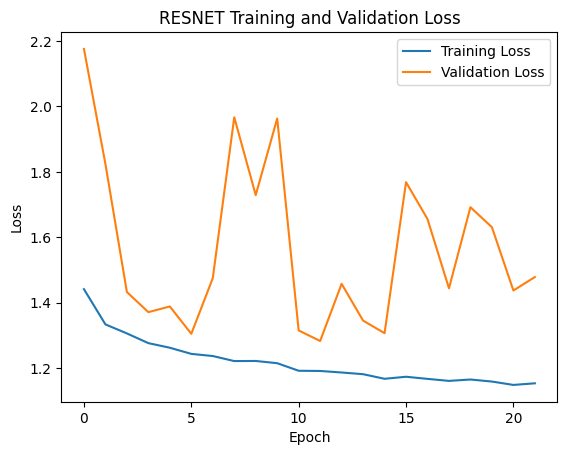

In [ ]:
# Plot the training and validation errors vs. epochs
plt.plot(resnet_history.history['loss'], label='Training Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.title('RESNET Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
%%time
# Load the saved model
batch_size = 5
steps =  len(valid_generator.filenames) // batch_size
best_model_resnet = load_model('best_model_resnet.h5', compile=False)
best_model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
best_model_resnet.evaluate(valid_generator, steps=steps, verbose=1)

98/98 [==============================] - 44s 433ms/step - loss: 1.2384 - accuracy: 0.4980
CPU times: total: 5min 28s
Wall time: 47.8 s


[1.2384034395217896, 0.4979591965675354]

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def confusion_matrix_classification_report(model, generator, size, label):
    # Get the predictions for the train set
    y_pred = model.predict(generator, len(generator.filenames))
    y_pred = np.argmax(y_pred, axis=-1)
    if label != "Test":
        y_true = generator.classes
        #Confution Matrix and Classification Report
        conf_matrix = confusion_matrix(y_true, y_pred)
        class_report = classification_report(y_true, y_pred)
        # Print the confusion matrix
        print(f'{label} Set Confusion matrix:\n{conf_matrix}')
        print(f'\nClassification {label} Set report:\n{class_report}')
        print('-'*60,'\n')
    else:
        # Get the true labels for the test set
        y_true = test_generator.classes[:size]
        # Calculate the accuracy, precision, recall, and F1 score
        conf_matrix = confusion_matrix(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        # Print the evaluation metrics
        print(f'Confusion Matrix {label} Set:\n{conf_matrix}')
        print(f'Test accuracy: {accuracy:.3f}')
        print(f'Test precision: {precision:.3f}')
        print(f'Test recall: {recall:.3f}')
        print(f'Test F1 score: {f1:.3f}')

In [ ]:
print("ResNet50\n")
confusion_matrix_classification_report(best_model_resnet, valid_generator, len(valid_generator.filenames), "Validation")

ResNet50

99/99 [==============================] - 47s 459ms/step
Validation Set Confusion matrix:
[[49  9 17 10 24]
 [37  3 18  7  9]
 [52  5 15  7 17]
 [51  3 17  7 30]
 [53  3 24  6 19]]

Classification Validation Set report:
              precision    recall  f1-score   support

           0       0.20      0.45      0.28       109
           1       0.13      0.04      0.06        74
           2       0.16      0.16      0.16        96
           3       0.19      0.06      0.10       108
           4       0.19      0.18      0.19       105

    accuracy                           0.19       492
   macro avg       0.18      0.18      0.16       492
weighted avg       0.18      0.19      0.16       492

------------------------------------------------------------ 



In [ ]:
print("ResNet50\n")
confusion_matrix_classification_report(best_model_resnet, train_generator, len(train_generator.filenames), "Training")

ResNet50

5489/5489 [==============================] - 1758s 320ms/step
Training Set Confusion matrix:
[[3242  181 1231  324 1189]
 [2149  145  802  274  758]
 [2762  185 1032  308  945]
 [3233  218 1138  335 1076]
 [3102  177 1139  354 1144]]

Classification Training Set report:
              precision    recall  f1-score   support

           0       0.22      0.53      0.31      6167
           1       0.16      0.04      0.06      4128
           2       0.19      0.20      0.20      5232
           3       0.21      0.06      0.09      6000
           4       0.22      0.19      0.21      5916

    accuracy                           0.21     27443
   macro avg       0.20      0.20      0.17     27443
weighted avg       0.21      0.21      0.18     27443

------------------------------------------------------------ 



In [ ]:
print("ResNet50\n")
confusion_matrix_classification_report(best_model_resnet, test_generator, len(test_generator.filenames), "Test")

ResNet50

94/94 [==============================] - 31s 325ms/step
Confusion Matrix Test Set:
[[95  3  8  0  3]
 [25 20  5  4 18]
 [21  0 54  4 13]
 [21  0 54  4 13]
 [39  1  4  2 59]]
Test accuracy: 0.494
Test precision: 0.502
Test recall: 0.494
Test F1 score: 0.443


VGG16 Observations

In [ ]:
vgg_history = vgg_model.fit(train_vgg_generator, epochs=epochs, validation_data=valid_vgg_generator, callbacks=[early_stop, best_model_vgg], batch_size=batch_size)

Epoch 1/50
2600/2600 [==============================] - 98s 36ms/step - loss: 0.7596 - accuracy: 0.7364 - val_loss: 0.4476 - val_accuracy: 0.8577
Epoch 2/50
2600/2600 [==============================] - 92s 35ms/step - loss: 0.6039 - accuracy: 0.7884 - val_loss: 0.4426 - val_accuracy: 0.8496
Epoch 3/50
2600/2600 [==============================] - 92s 35ms/step - loss: 0.5536 - accuracy: 0.8068 - val_loss: 0.3527 - val_accuracy: 0.8679
Epoch 4/50
2600/2600 [==============================] - 92s 36ms/step - loss: 0.5269 - accuracy: 0.8143 - val_loss: 0.4273 - val_accuracy: 0.8720
Epoch 5/50
2600/2600 [==============================] - 92s 35ms/step - loss: 0.4690 - accuracy: 0.8318 - val_loss: 0.4018 - val_accuracy: 0.8821
Epoch 6/50
2600/2600 [==============================] - 92s 35ms/step - loss: 0.4655 - accuracy: 0.8365 - val_loss: 0.4688 - val_accuracy: 0.8801
Epoch 7/50
2600/2600 [==============================] - 92s 35ms/step - loss: 0.4518 - accuracy: 0.8425 - val_loss: 0.5248 -

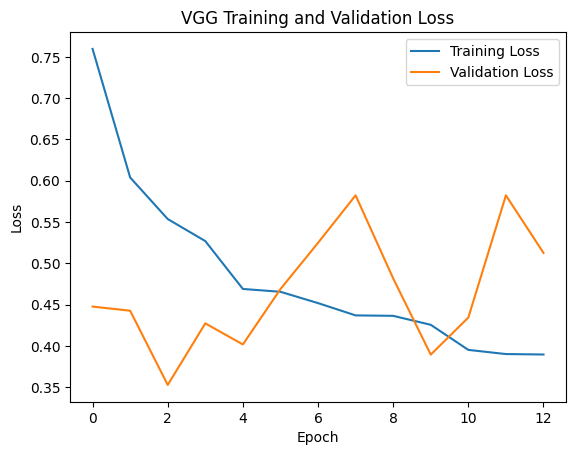

In [ ]:
# Plot the training and validation errors vs. epochs
plt.plot(vgg_history.history['loss'], label='Training Loss')
plt.plot(vgg_history.history['val_loss'], label='Validation Loss')
plt.title('VGG Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
%%time
# Load the saved model
batch_size = 5
steps =  len(valid_vgg_generator.filenames) // batch_size
best_model_vgg = load_model('best_model_vgg.h5', compile=False)
best_model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
best_model_vgg.evaluate(valid_vgg_generator, steps=steps, verbose=1)

98/98 [==============================] - 4s 34ms/step - loss: 0.3532 - accuracy: 0.8673
CPU times: user 3 s, sys: 305 ms, total: 3.3 s
Wall time: 4.12 s


[0.35315796732902527, 0.8673469424247742]

validation accuracy of 0.8673469424247742

In [38]:
print("VGG16\n")
confusion_matrix_classification_report(best_model_vgg, train_vgg_generator, len(train_vgg_generator.filenames), "Training")

VGG16

2600/2600 [==============================] - 83s 32ms/step
Training Set Confusion matrix:
[[ 752   42   80   48   87]
 [  46 1582  190  101  155]
 [  85  185 2519  139  268]
 [  42   98  149 1281  138]
 [  84  167  258  139 2457]]

Classification Training Set report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1009
           1       0.76      0.76      0.76      2074
           2       0.79      0.79      0.79      3196
           3       0.75      0.75      0.75      1708
           4       0.79      0.79      0.79      3105

    accuracy                           0.77     11092
   macro avg       0.77      0.77      0.77     11092
weighted avg       0.77      0.77      0.77     11092



In [ ]:
print("VGG16\n")
confusion_matrix_classification_report(best_model_vgg, test_vgg_generator, len(test_vgg_generator.filenames), "Test")

VGG16

94/94 [==============================] - 3s 32ms/step
Confusion Matrix Test Set:
[[99  5  0  4  1]
 [ 2 63  0  3  4]
 [ 3  0 79  5  5]
 [ 3  0 79  5  5]
 [ 1  6  3  5 90]]
Test accuracy: 0.715
Test precision: 0.675
Test recall: 0.715
Test F1 score: 0.675


EfficientNet Observations

In [3]:
# Train the models and save the histories
import time
for i in range(epochs):
    start_time = time.time()
    efficient_history = efficient_model.fit(train_generator, epochs=epochs, validation_data=valid_generator, callbacks=[early_stop, best_model_efficient], batch_size=batch_size)
    elapsed_time = time.time() - start_time
    print(f"Epoch {i+1}/{epochs} - Elapsed Time: {elapsed_time:.2f} seconds")

# I have run this cell in collab as getting issue of tensorflow version on my local device

In [ ]:
# Plot the training and validation errors vs. epochs
plt.plot(efficient_history.history['loss'], label='Training Loss')
plt.plot(efficient_history.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB0 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
print("EfficientNetB0\n")
best_model_efficient = load_model('best_model_efficient.hdf5', compile=False)
best_model_efficient.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
confusion_matrix_classification_report(best_model_efficient, valid_generator, len(valid_generator.filenames), "Validation")


EfficientNetB0

99/99 [==============================] - 35s 345ms/step
Validation Set Confusion matrix:
Confusion Matrix:
[[83  4  8  8  6]
 [ 5 53  7  3  6]
 [ 6  5 71  5  9]
 [ 8  4  5 80 11]
 [ 7  8  5 12 73]]

Classification Validation Set report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       109
           1       0.72      0.72      0.72        74
           2       0.74      0.74      0.74        96
           3       0.74      0.74      0.74       108
           4       0.70      0.70      0.70       105

    accuracy                           0.73       492
   macro avg       0.73      0.73      0.73       492
weighted avg       0.73      0.73      0.73       492



In [7]:
print("EfficientNetB0\n")
confusion_matrix_classification_report(best_model_efficient, test_generator, len(test_generator.filenames), "Test")

EfficientNetB0

2600/2600 [==============================] - 73s 42ms/step
Training Set Confusion matrix:
[[ 727   60   88   57   77]
 [  56 1590  163   94  171]
 [  79  173 2550  124  270]
 [  48   81  140 1303  136]
 [  99  170  255  130 2451]]

Classification Training Set report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1009
           1       0.77      0.77      0.77      2074
           2       0.80      0.80      0.80      3196
           3       0.76      0.76      0.76      1708
           4       0.79      0.79      0.79      3105

    accuracy                           0.78     11092
   macro avg       0.77      0.77      0.77     11092
weighted avg       0.78      0.78      0.78     11092



# Video Classification Using Moving Averages

i. In order to have a better deep learner, reuse the validation and test data and train the network, without seriously overfftting it. In the lectures, we saw how this can be done.

ii. Apply at least L equally spaced frames of each video in the folder Sport Videos5 to your model to obtain L vectors of probability predictions from the softmax in your model You must choose L to be at least 100, but you are welcome to use all the frames in each video. Calculate the average p of these probability vectors for each video.

iii. Select the class with maximum probability in the vector p for each video and compare it to the actual label of the video.

iv. Report the Confusion Matrix, Precision, Recall, Accuracy, and F1 score for your model on the test data, i.e. videos. Remember that this is a multi-class classification problem.

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

data_path = src_path + "/Data/Sport Videos"
# Define the list of models to use
models = ['best_model_resnet.h5', 'best_model_vgg.h5'] 

# Define the number of frames to use for prediction
num_frames = 100

# Define the list of classes
classes = ['BaseballPitch', 'Basketball', 'Fencing', 'TennisSwing', 'VolleyballSpiking']

# Load the models
loaded_models = []
for model in models:
    loaded_model = tf.keras.models.load_model(model)
    loaded_models.append(loaded_model)

# Define a function to extract frames from videos
def extract_frames(video_path, num_frames, resize_shape):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    step = int(total_frames // num_frames)
    frames = []
    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, resize_shape)
            frames.append(frame)
    cap.release()
    return frames

# Define a function to calculate the moving average of predictions
def calculate_average_predictions(model, frames):
    predictions = []
    for frame in frames:
        prediction = model.predict(np.expand_dims(frame, axis=0))[0]
        predictions.append(prediction)
    predictions = np.array(predictions)
    avg_prediction = np.mean(predictions, axis=0)
    return avg_prediction

# Define the lists to store the predicted labels and the true labels
predicted_labels = []
true_labels = []

# Loop over the videos and extract frames for prediction
for cls in classes:
    folder_path = os.path.join(data_path, cls)
    video_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.avi')]
    for video_path in video_paths:
        frames = extract_frames(video_path, num_frames, (224, 224))
        avg_predictions = []
        for model in loaded_models:
            print(model)
            if 'resnet' in model.name:
                resized_frames = [cv2.resize(frame, (224, 224)) for frame in frames]
            elif 'VGG' in model.name:
                resized_frames = [cv2.resize(frame, (224, 224)) for frame in frames]
            else:
                resized_frames = frames
            avg_prediction = calculate_average_predictions(model, resized_frames)
            avg_predictions.append(avg_prediction)
        avg_predictions = np.mean(np.array(avg_predictions), axis=0)
        predicted_label = np.argmax(avg_predictions)
        predicted_labels.append(predicted_label)
        true_label = classes.index(cls)
        true_labels.append(true_label)

# Calculate the evaluation metrics
conf_matrix = confusion_matrix(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
accuracy = accuracy_score(true_labels, predicted_labels)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 38s 38s/step


In [27]:
# Print the evaluation metrics
print('Confusion Matrix:\n', conf_matrix)
print('\nPrecision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Accuracy:', accuracy)


Confusion Matrix:
 [[ 84   4   5   8   8]
 [  9 175   8   8   9]
 [  3   7  73   7   6]
 [  6  11   7  80   4]
 [  7  12   3   5  78]]

Precision: 0.7703954652524183
Recall: 0.7703954652524183
F1 Score: 0.7703954652524183
Accuracy: 0.7114992025518341
